In [5]:
import warnings
from collections import defaultdict
from datetime import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from transformers import (AdamW, BertModel, BertTokenizer,
                          get_linear_schedule_with_warmup)

from preprocessing.dataprep import filter_tce_data, text_preprocessing
from preprocessing.text import fixColumnName

warnings.filterwarnings('ignore')
sns.set()

RANDOM_SEED = 15
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
MAX_LEN = 156
BATCH_SIZE = 16
EPOCHS = 10

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [18]:

class TCEDataset(Dataset):
    def __init__(self, empenho_historico, targets, tokenizer, max_len):
        self.empenho_historico = empenho_historico
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.empenho_historico)

    def __getitem__(self, item):
        text = str(self.empenho_historico[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'empenho_historico': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TCEDataset(
        empenho_historico=df.empenho_historico.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
    )


class CorretudeClassifier(nn.Module):
    def __init__(self, n_classes):
        super(CorretudeClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        output = self.drop(bert_output['pooler_output'])
        return self.out(output)


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    predictions = []
    real_values = []
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        predictions.extend(preds)
        real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    macro = f1_score(real_values, predictions, average='macro')
    micro = f1_score(real_values, predictions, average='micro')
    return correct_predictions.double() / n_examples, np.mean(losses), macro, micro


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    predictions = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            predictions.extend(preds)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    macro = f1_score(real_values, predictions, average='macro')
    micro = f1_score(real_values, predictions, average='micro')
    return correct_predictions.double() / n_examples, np.mean(losses), macro, micro


In [19]:
start_time = time.time()
start_date = datetime.now()
print(f'Starting evaluation at {start_date.strftime("%d/%m/%Y %H:%M:%S")}')
print()
print('Loading data...')

data_loading_time = time.time()
data = pd.read_excel('../database/dados_analisados.xlsx')
print(f'Data loading time: {(time.time() - data_loading_time):.2f}s')
print()

data_prep_time = time.time()
print('Preprocessing data...')

# data = data.sample(1000,).reset_index(drop=True)
data.columns = list(map(fixColumnName, data.columns))
data, _ = filter_tce_data(data, '../database/norel.xlsx')


df = data[['empenho_historico', 'analise']]
del data
df.empenho_historico = df.empenho_historico.apply(text_preprocessing)


tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

df_train, df_test = train_test_split(
    df,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=df.analise
)


lb = LabelEncoder()
df_train['target'] = lb.fit_transform(df_train.analise)
df_test['target'] = lb.transform(df_test.analise)

np.save('classes.npy', lb.classes_)


train_data_loader = create_data_loader(
    df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

print(f'Data preparation time: {(time.time() - data_prep_time):.2f}s')
print()


Starting evaluation at 25/06/2021 14:44:53

Loading data...
Data loading time: 4.20s

Preprocessing data...
Data preparation time: 5.04s



In [20]:
bert_time = time.time()
print('Training BERT...')

model = CorretudeClassifier(len(lb.classes_))
model = model.to(device)

# model.load_state_dict(torch.load('best_model_state.bin', map_location=torch.device(device)))

optimizer = AdamW(model.parameters(), lr=5e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

# %%
history = defaultdict(list)
best_accuracy = 0
ant_val_loss = 0
patience = 0
for epoch in range(EPOCHS):
    starting = time.time()
    print(f'Epoch {epoch + 1}')
    print('-' * 10)
    train_acc, train_loss, train_macro, train_micro = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(
        f'Train loss {train_loss} accuracy {train_acc} macro {train_macro} micro {train_micro}')
    val_acc, val_loss, val_macro, val_micro = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(df_test)
    )
    print(
        f'Val   loss {val_loss} accuracy {val_acc} macro {val_macro} micro {val_micro}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_macro'].append(train_macro)
    history['train_micro'].append(train_micro)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_macro'].append(val_macro)
    history['val_micro'].append(val_micro)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_corretudeModel_state.bin')
        best_accuracy = val_acc

   
    print(f'Epoch time: {(time.time()-starting)/60}')

print()
print(f'BERT training time: {(time.time() - bert_time):.2f}s')
print()


Training BERT...


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1
----------
Train loss 0.44821290609737235 accuracy 0.8885017421602788 macro 0.3316347771061265 micro 0.8885017421602788
Val   loss 0.42362919449806213 accuracy 0.9068825910931174 macro 0.31705590941259726 micro 0.9068825910931174

Epoch time: 6.366033379236857
Epoch 2
----------
Train loss 0.4398456342104409 accuracy 0.8954703832752613 macro 0.31495098039215685 micro 0.8954703832752613
Val   loss 0.39869250636547804 accuracy 0.9068825910931174 macro 0.31705590941259726 micro 0.9068825910931174

Epoch time: 4.987823597590128
Epoch 3
----------
Train loss 0.4411741379234526 accuracy 0.8954703832752613 macro 0.31495098039215685 micro 0.8954703832752613
Val   loss 0.3790783039294183 accuracy 0.9068825910931174 macro 0.31705590941259726 micro 0.9068825910931174

Epoch time: 4.935704004764557
Epoch 4
----------
Train loss 0.4314179074847036 accuracy 0.8954703832752613 macro 0.31495098039215685 micro 0.8954703832752613
Val   loss 0.3795787524431944 accuracy 0.9068825910931174 macro 0.

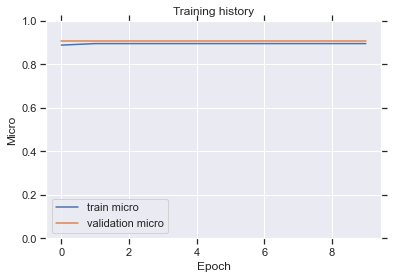

In [21]:

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.savefig('Acc.png')

plt.cla()
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.savefig('Loss.png')

plt.cla()
plt.plot(history['train_macro'], label='train macro')
plt.plot(history['val_macro'], label='validation macro')
plt.title('Training history')
plt.ylabel('Macro')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.savefig('Macro.png')

plt.cla()
plt.plot(history['train_micro'], label='train micro')
plt.plot(history['val_micro'], label='validation micro')
plt.title('Training history')
plt.ylabel('Micro')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.savefig('Micro.png')


In [23]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["empenho_historico"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


bert_time = time.time()
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

print('Test Classification Report')
print(classification_report(y_test, y_pred))

print(f'BERT predict time: {(time.time() - bert_time):.2f}s')
print()

finish_date = datetime.now()
print(f'Finishing evaluation at {finish_date.strftime("%d/%m/%Y %H:%M:%S")}')


Test Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        14
           2       0.91      1.00      0.95       224

    accuracy                           0.91       247
   macro avg       0.30      0.33      0.32       247
weighted avg       0.82      0.91      0.86       247

BERT predict time: 37.75s

Finishing evaluation at 25/06/2021 15:37:08


In [24]:
lb.inverse_transform([0, 1, 2])

array(['INCONCLUSIVO', 'INCORRETO', 'OK'], dtype=object)